<a href="https://colab.research.google.com/github/AgilAptanaDwiPutra/UAP_PRAKTIKUM/blob/main/UAP_MODEL_NON_PRETRAINED.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Menggunakan model FT-Transformer

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

Load dataset dan preprocessing

In [2]:
# Load dataset
df = pd.read_csv("dataset_lagu.csv")

# Convert boolean
df["explicit"] = df["explicit"].astype(int)

# Binary label
df["label"] = (df["popularity"] >= 50).astype(int)

FEATURES = [
    "duration_ms",
    "explicit",
    "danceability",
    "energy",
    "key",
    "loudness",
    "mode",
    "speechiness",
    "acousticness",
    "instrumentalness",
    "liveness",
    "valence",
    "tempo",
    "time_signature"
]

X = df[FEATURES].values
y = df["label"].values

# Normalize
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

Persiapan dataset untuk train

In [3]:
class SpotifyDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(
    SpotifyDataset(X_train, y_train),
    batch_size=128,
    shuffle=True
)

test_loader = DataLoader(
    SpotifyDataset(X_test, y_test),
    batch_size=128,
    shuffle=False
)

Model FNN

In [4]:
class FeedForwardNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.25),

            nn.Linear(128, 64),
            nn.ReLU(),

            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x).squeeze()

Training data

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = FeedForwardNN(input_dim=len(FEATURES)).to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

EPOCHS = 50

In [6]:
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(EPOCHS):
    # ===== TRAIN =====
    model.train()
    correct, total, train_loss = 0, 0, 0

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        preds = model(X_batch)
        loss = criterion(preds, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        predicted = (preds >= 0.5).float()
        correct += (predicted == y_batch).sum().item()
        total += y_batch.size(0)

    train_losses.append(train_loss / len(train_loader))
    train_accs.append(correct / total)

    # ===== VALIDATION =====
    model.eval()
    correct, total, val_loss = 0, 0, 0

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            preds = model(X_batch)
            loss = criterion(preds, y_batch)
            val_loss += loss.item()

            predicted = (preds >= 0.5).float()
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)

    val_losses.append(val_loss / len(test_loader))
    val_accs.append(correct / total)

    print(
        f"Epoch {epoch+1:02d} | "
        f"Train Acc: {train_accs[-1]:.3f} | "
        f"Val Acc: {val_accs[-1]:.3f}"
    )

Epoch 01 | Train Acc: 0.743 | Val Acc: 0.743
Epoch 02 | Train Acc: 0.743 | Val Acc: 0.744
Epoch 03 | Train Acc: 0.744 | Val Acc: 0.746
Epoch 04 | Train Acc: 0.744 | Val Acc: 0.745
Epoch 05 | Train Acc: 0.744 | Val Acc: 0.747
Epoch 06 | Train Acc: 0.745 | Val Acc: 0.747
Epoch 07 | Train Acc: 0.745 | Val Acc: 0.746
Epoch 08 | Train Acc: 0.746 | Val Acc: 0.746
Epoch 09 | Train Acc: 0.746 | Val Acc: 0.747
Epoch 10 | Train Acc: 0.746 | Val Acc: 0.748
Epoch 11 | Train Acc: 0.746 | Val Acc: 0.747
Epoch 12 | Train Acc: 0.747 | Val Acc: 0.747
Epoch 13 | Train Acc: 0.746 | Val Acc: 0.748
Epoch 14 | Train Acc: 0.747 | Val Acc: 0.749
Epoch 15 | Train Acc: 0.748 | Val Acc: 0.749
Epoch 16 | Train Acc: 0.747 | Val Acc: 0.748
Epoch 17 | Train Acc: 0.748 | Val Acc: 0.748
Epoch 18 | Train Acc: 0.748 | Val Acc: 0.750
Epoch 19 | Train Acc: 0.748 | Val Acc: 0.748
Epoch 20 | Train Acc: 0.749 | Val Acc: 0.752
Epoch 21 | Train Acc: 0.749 | Val Acc: 0.749
Epoch 22 | Train Acc: 0.749 | Val Acc: 0.749
Epoch 23 |

Pengambilan probabilitas

In [8]:
model.eval()
probs_list = []
y_true = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)

        # Karena model kamu pakai Sigmoid di akhir
        probs = model(X_batch).cpu().numpy()

        probs_list.extend(probs)
        y_true.extend(y_batch.numpy())

import numpy as np
probs_list = np.array(probs_list).reshape(-1)
y_true = np.array(y_true).astype(int)

Evaluasi

In [9]:
from sklearn.metrics import classification_report

FINAL_THRESHOLD = 0.5

y_pred_final = (probs_list >= FINAL_THRESHOLD).astype(int)

print("Classification Report (Final Model, threshold=0.29)")
print(classification_report(
    y_true,
    y_pred_final,
    target_names=["Not Popular", "Popular"]
))

Classification Report (Final Model, threshold=0.29)
              precision    recall  f1-score   support

 Not Popular       0.77      0.96      0.85     16927
     Popular       0.58      0.17      0.26      5873

    accuracy                           0.75     22800
   macro avg       0.67      0.56      0.56     22800
weighted avg       0.72      0.75      0.70     22800



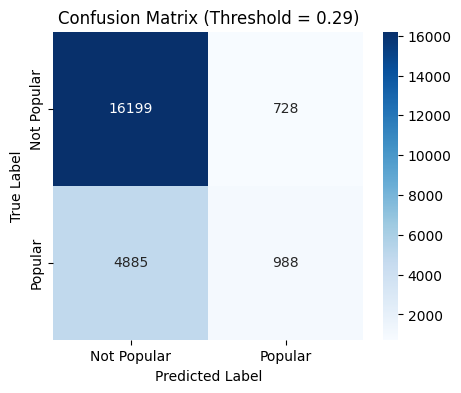

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred_final)

plt.figure(figsize=(5, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Not Popular", "Popular"],
    yticklabels=["Not Popular", "Popular"]
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Threshold = 0.29)")
plt.show()

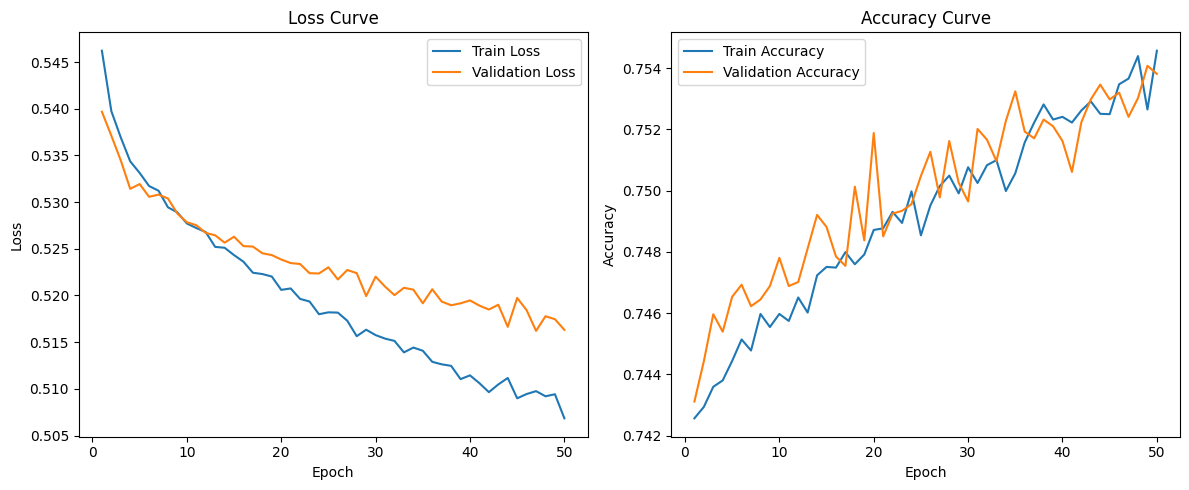

In [11]:
epochs = range(1, EPOCHS + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accs, label="Train Accuracy")
plt.plot(epochs, val_accs, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()

plt.tight_layout()
plt.show()

In [12]:
import torch
import joblib
import json

In [13]:
# ============================
# SAVE MODEL & PREPROCESSOR
# ============================

MODEL_PATH = "spotify_popularity_model.pth"
SCALER_PATH = "spotify_scaler.pkl"
CONFIG_PATH = "model_config.json"

# Simpan model weights
torch.save(model.state_dict(), MODEL_PATH)

# Simpan scaler
joblib.dump(scaler, SCALER_PATH)

# Simpan config (feature & threshold)
config = {
    "features": FEATURES,
    "threshold": 0.29,   # threshold final hasil tuning
    "model_type": "Feedforward Neural Network",
    "task": "Binary Classification (Popularity)"
}

with open(CONFIG_PATH, "w") as f:
    json.dump(config, f, indent=4)

print("Model, scaler, dan config berhasil disimpan")

Model, scaler, dan config berhasil disimpan
